In [18]:
import pynbody as pb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm as LN
import numpy as np
from pynbody.array import SimArray as SRA

In [2]:
starlog=pb.tipsy.StarLog('../chkcombine/chkcombine.starlog')

/Users/betha1/Library/Python/3.9/lib/python/site-packages/pynbody/snapshot/tipsy.py:1201: UserWarning: log file found, but there was a problem with the starlog metadata. Reverting to guess-and-check
  warnings.warn('log file found, but there was a problem with the starlog metadata. '


In [3]:
starlog

<SimSnap "../chkcombine/chkcombine.starlog" len=8499>

In [5]:
starlog.keys()

['pos',
 'x',
 'y',
 'z',
 'vel',
 'vx',
 'vy',
 'vz',
 'iord',
 'iorderGas',
 'massform',
 'rhoform',
 'tempform',
 'metals',
 'tform']

In [6]:
starlog['x']

SimArray([-2.00892458e+00,  8.90845564e-04, -2.38883524e+00, ...,
          -3.55880719e+00, -3.01725815e+00, -3.64312650e+00], 'kpc')

In [9]:
starlog['iord']

SimArray([536011, 536012, 536013, ..., 544507, 544508, 544509],
         dtype=int32)

In [10]:
starlog['tform']

SimArray([6.000625, 6.000625, 6.000625, ..., 7.      , 7.      , 7.      ], '9.79e-01 Gyr')

In [36]:
def rform(simin, starlog, com_times,comtxt, long='no'):

    """
    This calculates rform, zform and rformspherical using the starlog
    center of mass.

    Returns: rform, zform, rform_spherical or if long = yes Returns
    xform, yform, zform
    """
    # simin.physical_units()

    # Now load in the posform and store it in x/y/zform variable

    posform = starlog.s['pos'][:len(simin.s)]
    x_starlog = starlog['x'][(starlog['iord']<=np.max(simin.s['iord']))]#posform[:, 0]
    y_starlog = starlog['y'][(starlog['iord']<=np.max(simin.s['iord']))]#posform[:, 1]
    z_starlog = starlog['z'][(starlog['iord']<=np.max(simin.s['iord']))]#posform[:, 2]
    tform = starlog['tform'][(starlog['iord']<=np.max(simin.s['iord']))]#simin.s['tform']

    # Now need to import the COM information from file.
    # data = np.genfromtxt(
    #     fname=comtxt, names='xcom,ycom,zcom,xang,yang,zang')
    xcom = comtxt[:,0][:len(com_times)]
    ycom = comtxt[:,1][:len(com_times)]
    zcom = comtxt[:,2][:len(com_times)]
    xang = comtxt[:,3][:len(com_times)]
    yang = comtxt[:,4][:len(com_times)]
    zang = comtxt[:,5][:len(com_times)]

    # Do a sanity check that xp is increasing (otherwise np.interp returns
    # nonsensical values)
    if(np.all(np.diff(com_times) > 0)):
        xcom_interp = np.interp(tform, com_times, xcom)
        ycom_interp = np.interp(tform, com_times, ycom)
        zcom_interp = np.interp(tform, com_times, zcom)
        xang_interp = np.interp(tform, com_times, xang)
        yang_interp = np.interp(tform, com_times, yang)
        zang_interp = np.interp(tform, com_times, zang)
    else:
        raise Exception('com_times does not increase')

    # Recenter on the COM at that tform
    x_starlog = x_starlog - xcom_interp
    y_starlog = y_starlog - ycom_interp
    z_starlog = z_starlog - zcom_interp

    # Calculate the dot product of rform and the ang mom vectors
    rdotj = (x_starlog*xang_interp +
             y_starlog*yang_interp + z_starlog*zang_interp)
    jmag = np.sqrt(xang_interp**2 + yang_interp**2 + zang_interp**2)

    # Set 0 vectors to something small but non zero
    jmag[jmag == 0] = 0.00000001

    rmag = np.sqrt(x_starlog**2 + y_starlog**2 + z_starlog**2)

    zform = np.empty(len(simin.s))
    zform = rdotj / jmag

    rform = np.empty(len(simin.s))
    rform = np.sqrt(rmag**2 - zform**2)

    rform_spherical = rmag

    if long == 'no':
        return SRA(rform,units='kpc'), SRA(zform,units='kpc'), SRA(rform_spherical,units='kpc')
    if long == 'yes':
        return SRA(x_starlog,units='kpc'), SRA(y_starlog,units='kpc'), SRA(z_starlog,units='kpc')

In [37]:
COM=np.zeros((50,6))
r=pb.filt.BandPass('r','0 kpc','2 kpc')
k=0
for i in range(602,702,2):
    sim=pb.load('../chkcombine/chkcombine.%05d'%i)
    lmc = sim.s[:186675]
    COM[k][:3]=pb.analysis.halo.center(lmc,mode='hyb',retcen=True)
    pb.analysis.halo.center(lmc,mode='hyb',retcen=False)
    COM[k][3:]=pb.analysis.angmom.ang_mom_vec(lmc[r])
    k+=1
sim=pb.load('../chkcombine/chkcombine.%05d'%700)
starlog=pb.tipsy.StarLog('../chkcombine/chkcombine.starlog')
FORM=rform(sim,starlog,np.arange(6.02,7.0,.02),COM,long='yes')
#sim.s['x_form'],sim.s['y_form'],sim.s['z_form']=FORM
#sim.s['t_form'] = starlog['tform'][0:len(sim.s)]

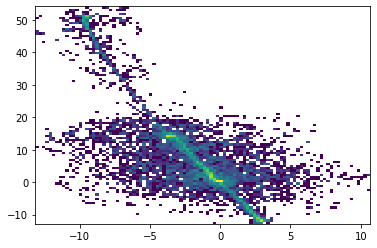

In [35]:
plt.hist2d(starlog['x'],starlog['y'],bins=100,norm=LN())
plt.show()

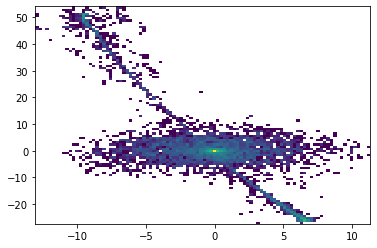

In [38]:
plt.hist2d(FORM[0],FORM[1],bins=100,norm=LN())
plt.show()

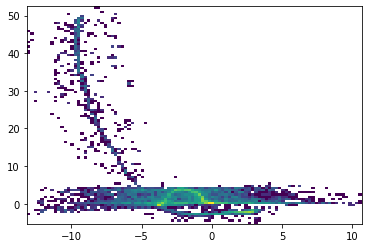

In [31]:
plt.hist2d(starlog['x'],starlog['z'],bins=100,norm=LN())
plt.show()

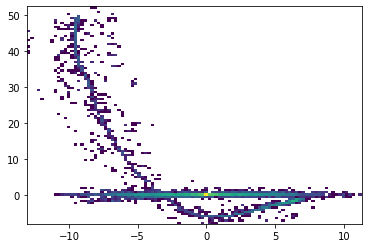

In [39]:
plt.hist2d(FORM[0],FORM[2],bins=100,norm=LN())
plt.show()

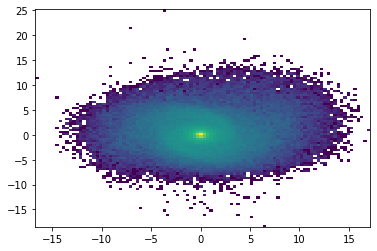

In [28]:
plt.hist2d(lmc['x'],lmc['y'],bins=100,norm=LN())
plt.show()

In [30]:
COM

array([[-2.95590441e-03,  1.88817642e-02,  2.08957578e-02,
         4.76613917e+03,  4.74413169e+03, -3.70947600e+05],
       [-4.45845049e-02,  4.13821681e-02,  4.07583335e-02,
         6.80241270e+03,  5.93445053e+03, -3.73089938e+05],
       [-4.36577710e-02,  8.47694176e-02,  5.97612219e-02,
         6.43377712e+03,  6.09548420e+03, -3.73169240e+05],
       [-2.64440160e-02,  1.36725991e-01,  7.91778846e-02,
         6.37453316e+03,  5.90691190e+03, -3.74378726e+05],
       [-2.54134150e-02,  1.52955031e-01,  8.34578400e-02,
         5.09300133e+03,  6.31192720e+03, -3.76133861e+05],
       [-2.26751413e-02,  1.70340764e-01,  8.45450649e-02,
         5.52138010e+03,  7.54825131e+03, -3.76381712e+05],
       [-3.30362441e-02,  2.20622496e-01,  8.25543648e-02,
         4.83233385e+03,  8.63473365e+03, -3.72443562e+05],
       [-4.22784416e-02,  2.20469645e-01,  9.40565711e-02,
         3.92113746e+03,  7.23669252e+03, -3.68798587e+05],
       [-7.40523235e-02,  2.68040656e-01,  1.069